In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
from scipy.fft import rfft, rfftfreq, fft
from scipy.signal import butter, filtfilt, find_peaks, lfilter
from scipy.ndimage import median_filter


In [132]:
# Parameters for recording
# ( chords , freq) x (freq, time)
CHUNK = 1024            # Number of audio samples per buffer
FORMAT = pyaudio.paInt16  # each sample is 16 bit
CHANNELS = 1            # Mono audio
RATE = 44100            # Sampling rate in Hz -> how many samples per second
RECORD_SECONDS = 5      # Duration of recording in seconds
AUDIO_FILE = './utils/assets/lewis_capaldi.mp3'
NUMBER_OF_CHUNKS = int(RATE / CHUNK * RECORD_SECONDS)

In [133]:

def from_raw_to_array_of_chunks(raw_audio_data):
    return [raw_audio_data[i:i + CHUNK] for i in range(0, len(raw_audio_data), CHUNK)]
   
def from_array_of_chunks_to_array_of_int(array_of_chunks):
    return np.frombuffer(b''.join(array_of_chunks), dtype=np.int16)

def from_mp3(file_path):

    audio_file_path = file_path  # Replace with your MP3 file path
    audio = AudioSegment.from_mp3(audio_file_path)
    
    # Convert the audio to raw PCM data (in this case, 16-bit mono)
    audio = audio.set_channels(1)  # Ensure mono
    audio = audio.set_frame_rate(RATE)  # Match the desired sample rate
    
    # Convert audio to raw bytes
    raw_audio_data = audio.raw_data
    
    # Process the audio data in chunks as you would with live input
    frames = from_raw_to_array_of_chunks(raw_audio_data)
    
    return from_array_of_chunks_to_array_of_int(frames)
    

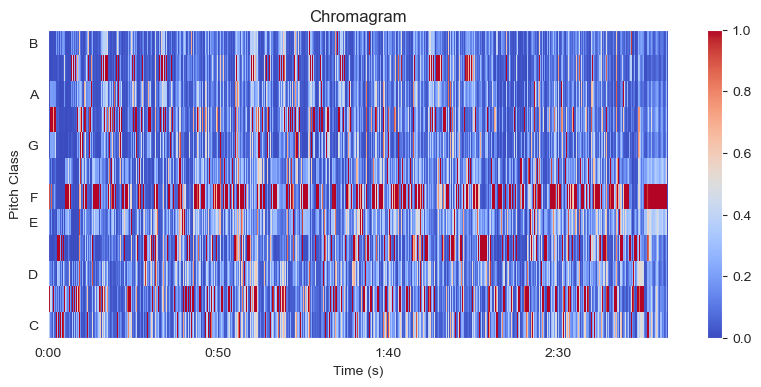

In [134]:
y, sr = librosa.load(AUDIO_FILE, dtype="float32")

# Compute the chromagram
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Display the chromagram
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, x_axis="time", y_axis="chroma", cmap="coolwarm")
plt.colorbar()
plt.title("Chromagram")
plt.xlabel("Time (s)")
plt.ylabel("Pitch Class")
plt.show()

# GPT

In [135]:
from librosa.core.spectrum import stft
from librosa.core.pitch import estimate_tuning
from librosa import filters
from librosa import util

def chroma_stft(
    *,
    y = None,
    sr: float = 22050,
    S = None,
    norm= np.inf,
    n_fft: int = 2048,
    hop_length: int = 512,
    win_length= None,
    window = "hann",
    center: bool = True,
    pad_mode = "constant",
    tuning= None,
    n_chroma: int = 12,
    **kwargs,
) -> np.ndarray:
    """Compute a chromagram from a waveform or power spectrogram.
    Parameters
    ----------
    y : np.ndarray [shape=(..., n)] or None
        audio time series. Multi-channel is supported.
    sr : number > 0 [scalar]
        sampling rate of ``y``
    S : np.ndarray [shape=(..., d, t)] or None
        power spectrogram
    norm : float or None
        Column-wise normalization.
        See `librosa.util.normalize` for details.
        If `None`, no normalization is performed.
    n_fft : int  > 0 [scalar]
        FFT window size if provided ``y, sr`` instead of ``S``
    hop_length : int > 0 [scalar]
        hop length if provided ``y, sr`` instead of ``S``
    win_length : int <= n_fft [scalar]
        Each frame of audio is windowed by `window()`.
        The window will be of length `win_length` and then padded
        with zeros to match ``n_fft``.
        If unspecified, defaults to ``win_length = n_fft``.
    window : string, tuple, number, function, or np.ndarray [shape=(n_fft,)]
        - a window specification (string, tuple, or number);
          see `scipy.signal.get_window`
        - a window function, such as `scipy.signal.windows.hann`
        - a vector or array of length ``n_fft``
        .. see also:: `librosa.filters.get_window`
    center : boolean
        - If `True`, the signal ``y`` is padded so that frame
          ``t`` is centered at ``y[t * hop_length]``.
        - If `False`, then frame ``t`` begins at ``y[t * hop_length]``
    pad_mode : string
        If ``center=True``, the padding mode to use at the edges of the signal.
        By default, STFT uses zero padding.
    tuning : float [scalar] or None.
        Deviation from A440 tuning in fractional chroma bins.
        If `None`, it is automatically estimated.
    n_chroma : int > 0 [scalar]
        Number of chroma bins to produce (12 by default).
    **kwargs : additional keyword arguments to parameterize chroma filters.
    ctroct : float > 0 [scalar]
    octwidth : float > 0 or None [scalar]
        ``ctroct`` and ``octwidth`` specify a dominance window:
        a Gaussian weighting centered on ``ctroct`` (in octs, A0 = 27.5Hz)
        and with a gaussian half-width of ``octwidth``.
        Set ``octwidth`` to `None` to use a flat weighting.
    norm : float > 0 or np.inf
        Normalization factor for each filter
    base_c : bool
        If True, the filter bank will start at 'C'.
        If False, the filter bank will start at 'A'.
    dtype : np.dtype
        The data type of the output basis.
        By default, uses 32-bit (single-precision) floating point.
    """
    POWER = 2
    S = (
            np.abs(
                stft(
                    y,
                    n_fft=n_fft,
                    hop_length=hop_length,
                    win_length=win_length,
                    center=center,
                    window=window,
                    pad_mode=pad_mode,
                )
            )
            ** POWER
        )

    if tuning is None:
        tuning = estimate_tuning(S=S, sr=sr, bins_per_octave=n_chroma)

    # Get the filter bank
    chromafb = filters.chroma(
        sr=sr, n_fft=n_fft, tuning=tuning, n_chroma=n_chroma, **kwargs
    )

    # Compute raw chroma
    # EQUIVALENT TO raw_chroma = np.dot(chromafb, S)
    # (bins , frequencies) x (frequencies, time) -> (bins, time)
    raw_chroma = np.einsum("cf,...ft->...ct", chromafb, S, optimize=True)
    
    # Compute normalization factor for each frame
    return util.normalize(raw_chroma, norm=norm, axis=-2)


In [136]:
def display_chromagram(chroma):
    plt.figure(figsize=(20, 4))
    librosa.display.specshow(chroma, x_axis="time", y_axis="chroma", cmap="coolwarm")
    plt.colorbar(label="Magnitude")
    plt.title("Chromagram (Using Custom chroma_stft Function)")
    plt.xlabel("Time (s)")
    plt.ylabel("Pitch Class")
    plt.show()

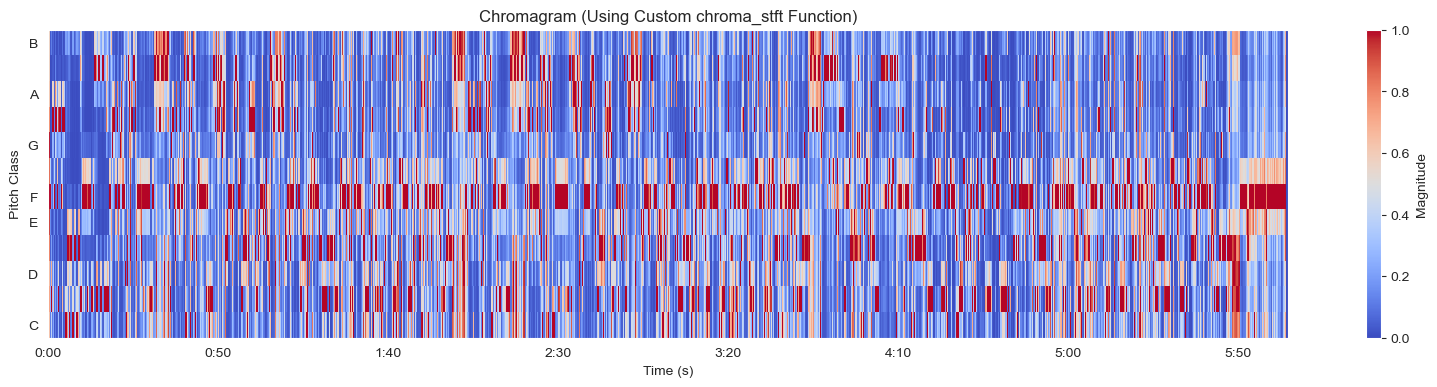

In [137]:
import numpy as np
import matplotlib.pyplot as plt

def from_mp3(file_path):
    audio = AudioSegment.from_mp3(file_path)
    audio = audio.set_channels(1)
    audio = audio.set_frame_rate(RATE)
    raw_audio_data = np.frombuffer(audio.raw_data, dtype=np.int16)
    return raw_audio_data.astype(np.float32) / np.iinfo(np.int16).max  # Normalize to [-1,1]

# Load Audio
sample_rate = RATE
audio = from_mp3(AUDIO_FILE)

# STFT Parameters
window_size = 2048
hop_size = 512

# Compute Chroma using your function
chroma = chroma_stft(y=audio, sr=sample_rate)

display_chromagram(chroma)


In [138]:
import numpy as np

def time_to_index(time, sr, hop_length):
    """
    Converts time to index.

    Parameters:
    - time (float): Time in seconds.
    - sr (int): Sampling rate of the audio.
    - hop_length (int): Hop size used in STFT.

    Returns:
    - int: Index corresponding to the time.
    """
    time_per_column = hop_length / sr
    return int(time / time_per_column)
def index_to_time(index, sr, hop_length):
    """
    Converts index to time.

    Parameters:
    - index (int): Index.
    - sr (int): Sampling rate of the audio.
    - hop_length (int): Hop size used in STFT.

    Returns:
    - float: Time in seconds corresponding to the index.
    """
    time_per_column = hop_length / sr
    return index * time_per_column

def cut_time(chroma_matrix, start_time, end_time, sr, hop_length):
    """
    Cuts a time segment from a chroma matrix.

    Parameters:
    - chroma_matrix (np.ndarray): The chroma matrix (shape: 12 x num_time_frames).
    - start_time (float): The start time in seconds.
    - end_time (float): The end time in seconds.
    - sr (int): Sampling rate of the audio.
    - hop_length (int): Hop size used in STFT.

    Returns:
    - np.ndarray: Cropped chroma matrix.
    """

    # Convert times to indices
    start_index = time_to_index(start_time, sr, hop_length)
    end_index = time_to_index(end_time, sr, hop_length)

    # Ensure indices are within bounds
    start_index = max(0, start_index)
    end_index = min(chroma_matrix.shape[1], end_index)

    # Slice the chroma matrix
    return chroma_matrix[:, start_index:end_index]

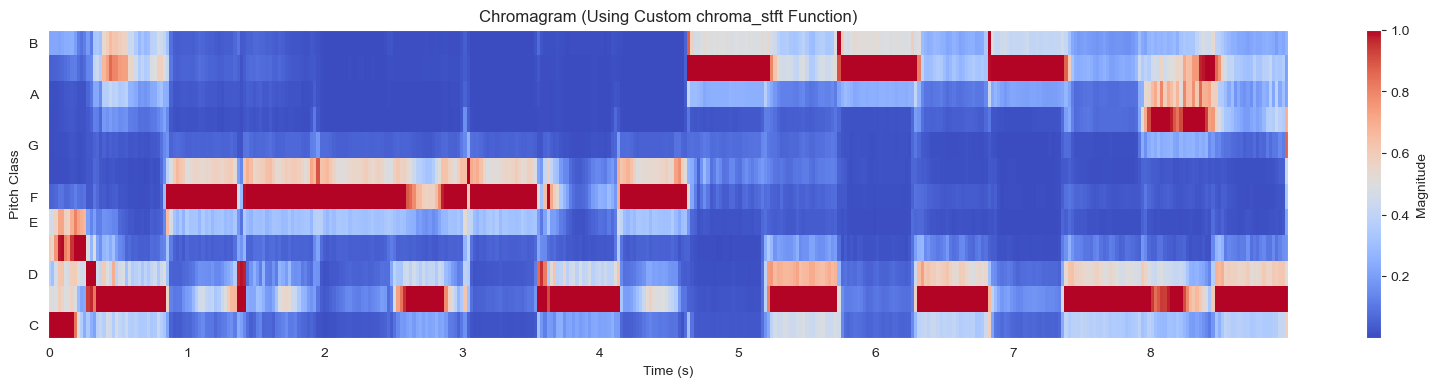

In [139]:
cut_chroma = cut_time(chroma , 9, 18, sr, hop_size)
display_chromagram(cut_chroma)

In [140]:
time_to_index(9, sr, hop_size)

387

In [141]:
idx = time_to_index(10, sr, hop_size)
frequencies = chroma[:, idx]

In [142]:
frequencies

array([0.06163417, 0.19219355, 0.0740917 , 0.06386517, 0.3565765 ,
       1.        , 0.50765073, 0.04742005, 0.01326385, 0.02887637,
       0.05591308, 0.0455155 ], dtype=float32)

In [143]:
notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
note = notes[np.argmax(frequencies)]

In [144]:
note

'F'

In [145]:
def get_note_from_second(chroma, second,hop_size, sr):
    idx = time_to_index(second, sr, hop_size)
    frequencies = chroma[:, idx]
    notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    return notes[np.argmax(frequencies)]

In [146]:
get_note_from_second(chroma, 9.4, hop_size, sr)

'C#'

In [147]:
def get_note_from_time(chroma, hop_size, sr, min, sec, millisec=0):
    return get_note_from_second(chroma, min * 60 + sec + millisec / 1000, hop_size, sr)

In [148]:
get_note_from_time(chroma, hop_size, sr, min=0, sec=9, millisec=400)

'C#'

# Reducing horizontal noise
 Our chroma matrix is nothing else than a 2d signal. We can apply filters to it to smooth it out.
 Here I'm trying two different filters: median and gaussian.

In [149]:
from scipy.ndimage import median_filter, gaussian_filter

def smooth_chroma_median(chroma_matrix, kernel_size=3):
    
    return median_filter(chroma_matrix, size=(1, kernel_size))  # Apply along time axis

def smooth_chroma_gaussian(chroma_matrix, sigma=1):
   
    return gaussian_filter(chroma_matrix, sigma=(0, sigma))  # Apply along time axis


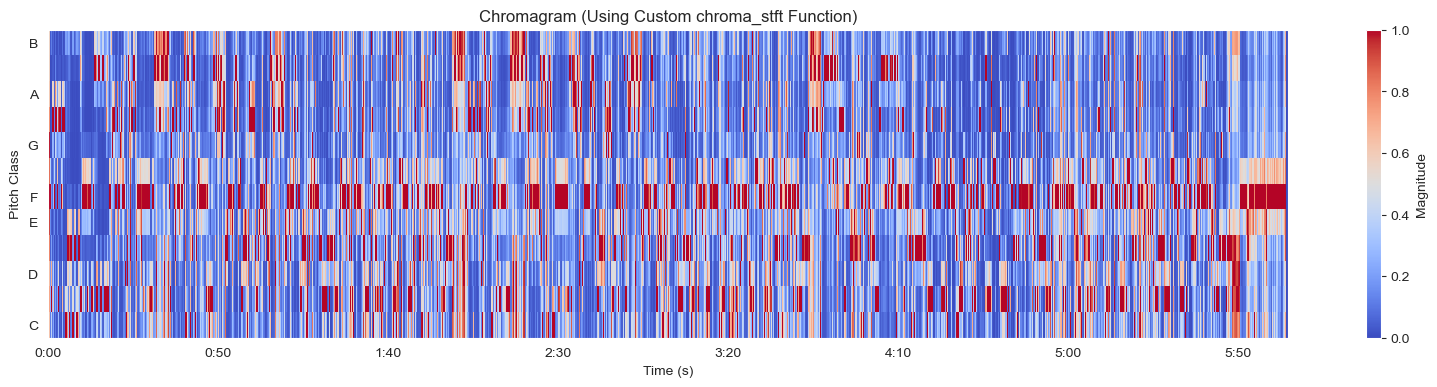

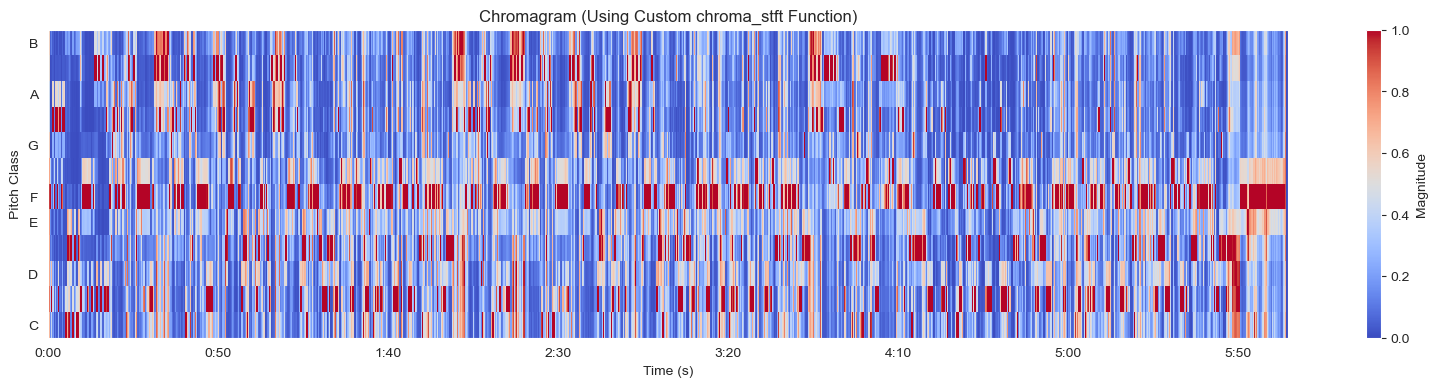

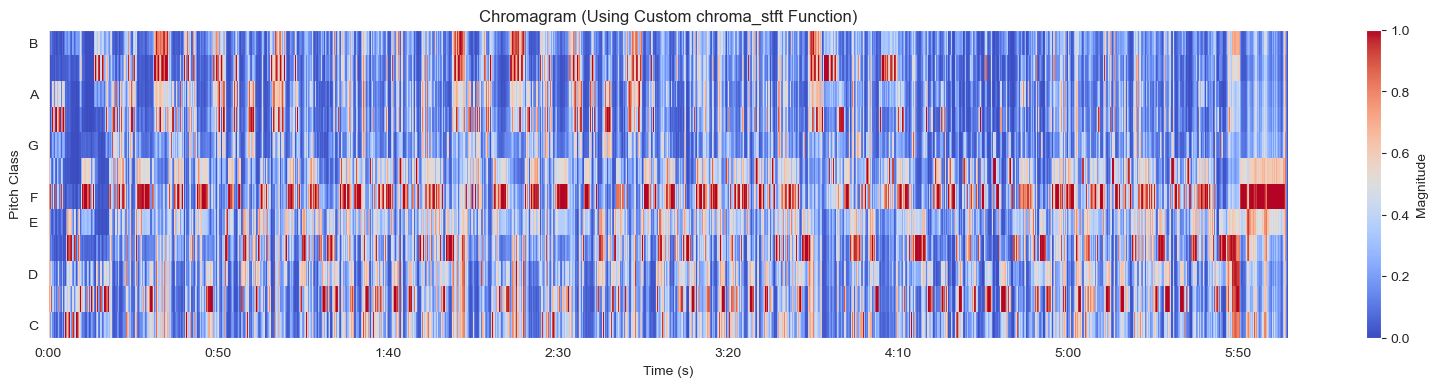

In [150]:
median_smoothed_chroma = smooth_chroma_median(chroma, kernel_size=16)
gaussian_smoothed_chroma = smooth_chroma_gaussian(chroma, sigma=4) 

display_chromagram(chroma)
display_chromagram(median_smoothed_chroma)
display_chromagram(gaussian_smoothed_chroma)


In [151]:
def create_and_smooth_chroma(file_path, kernel_size=3, sigma=1):
    audio = from_mp3(file_path)
    chroma = chroma_stft(y=audio, sr=RATE)
    median_smoothed_chroma = smooth_chroma_median(chroma, kernel_size)
    gaussian_smoothed_chroma = smooth_chroma_gaussian(chroma, sigma)
    return chroma, median_smoothed_chroma, gaussian_smoothed_chroma

In [152]:
chroma, median_smoothed_chroma, _ = create_and_smooth_chroma(AUDIO_FILE, kernel_size=16, sigma=4)


In [153]:
chroma[:, time_to_index(15, sr, hop_size)]

array([0.06842927, 0.09757578, 0.06612454, 0.01940976, 0.00417158,
       0.00751774, 0.01252794, 0.0111501 , 0.01633259, 0.2504264 ,
       1.        , 0.51101834], dtype=float32)

In [154]:
chord_templates = {
    "C Major":   [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  # C-E-G
    "C# Major":  [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],  # C#-F-G#
    "D Major":   [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],  # D-F#-A
    "D# Major":  [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],  # D#-G-A#
    "E Major":   [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],  # E-G#-B
    "F Major":   [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],  # F-A-C
    "F# Major":  [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],  # F#-A#-C#
    "G Major":   [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],  # G-B-D
    "G# Major":  [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],  # G#-C-D#
    "A Major":   [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],  # A-C#-E
    "A# Major":  [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],  # A#-D-F
    "B Major":   [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],  # B-D#-F#

    "C Minor":   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],  # C-E♭-G
    "C# Minor":  [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],  # C#-E-G#
    "D Minor":   [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],  # D-F-A
    "D# Minor":  [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],  # D#-F#-A#
    "E Minor":   [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],  # E-G-B
    "F Minor":   [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],  # F-G#-C
    "F# Minor":  [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],  # F#-A-C#
    "G Minor":   [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],  # G-A#-D
    "G# Minor":  [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],  # G#-B-D#
    "A Minor":   [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],  # A-C-E
    "A# Minor":  [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],  # A#-C#-F
    "B Minor":   [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],  # B-D-F#
}


In [155]:
def cosine_similarity(a, b):
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)

    if norm_a == 0 or norm_b == 0:
        return 0  # Return 0 instead of NaN if one vector is zero
    
    return np.dot(a, b) / (norm_a * norm_b)

In [156]:
def similarity_scores(freq_array, chord_templates):
    scores = {}
    for chord_name, chord_template in chord_templates.items():
        scores[chord_name] = cosine_similarity(freq_array, chord_template)
    return scores

In [157]:
similarity_scores(chroma[:, time_to_index(15, sr, hop_size)], chord_templates)

{'C Major': 0.04171785035534747,
 'C# Major': 0.06048452800225076,
 'D Major': 0.16392010783996366,
 'D# Major': 0.5133403789253087,
 'E Major': 0.26476090870900126,
 'F Major': 0.16257246430721395,
 'F# Major': 0.552962600552758,
 'G Major': 0.29303930002803086,
 'G# Major': 0.051889758249604304,
 'A Major': 0.17542407843597194,
 'A# Major': 0.5348005079517631,
 'B Major': 0.2704561547496688,
 'C Minor': 0.04930826422874351,
 'C# Minor': 0.06048452800225076,
 'D Minor': 0.16392010783996366,
 'D# Minor': 0.5133403789253087,
 'E Minor': 0.26476090870900126,
 'F Minor': 0.16257246430721395,
 'F# Minor': 0.552962600552758,
 'G Minor': 0.29303930002803086,
 'G# Minor': 0.051889758249604304,
 'A Minor': 0.17542407843597194,
 'A# Minor': 0.5348005079517631,
 'B Minor': 0.2704561547496688}

In [159]:
def get_top_n(scores, n=6):
    return dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n])

In [160]:
get_top_n(similarity_scores(chroma[:, time_to_index(9, sr, hop_size)], chord_templates))

{'G# Major': 0.6531483133393021,
 'G# Minor': 0.6531483133393021,
 'C Minor': 0.651639144179098,
 'C Major': 0.5920534175849678,
 'F Major': 0.4275110994974649,
 'F Minor': 0.4275110994974649}

In [161]:
def chord_scores_list(chroma, chord_templates, n=6):
    scores_list = []
  
    for i in range(chroma.shape[1]):
        
        scores = similarity_scores(chroma[:, i], chord_templates)
        scores["time"] = index_to_time(i, sr, hop_size)
        scores_list.append(scores)
    return scores_list

In [162]:
chord_scores = chord_scores_list(chroma, chord_templates)
chord_scores[3000:4000]

[{'C Major': 0.3500084829432806,
  'C# Major': 0.32049816652012103,
  'D Major': 0.4070174664372068,
  'D# Major': 0.5795326846879707,
  'E Major': 0.4510652858185634,
  'F Major': 0.3814148450828997,
  'F# Major': 0.5574094211226528,
  'G Major': 0.5073215308945221,
  'G# Major': 0.3897593336813746,
  'A Major': 0.3833365144864815,
  'A# Major': 0.618572568195504,
  'B Major': 0.5181666712514728,
  'C Minor': 0.3939457727825811,
  'C# Minor': 0.32049816652012103,
  'D Minor': 0.4070174664372068,
  'D# Minor': 0.5795326846879707,
  'E Minor': 0.4510652858185634,
  'F Minor': 0.3814148450828997,
  'F# Minor': 0.5574094211226528,
  'G Minor': 0.5073215308945221,
  'G# Minor': 0.3897593336813746,
  'A Minor': 0.3833365144864815,
  'A# Minor': 0.618572568195504,
  'B Minor': 0.5181666712514728,
  'time': 69.65986394557824},
 {'C Major': 0.39084453036650996,
  'C# Major': 0.3681541418262523,
  'D Major': 0.36062440031038534,
  'D# Major': 0.5109063060002567,
  'E Major': 0.47540767467047335

# Into Pandas df

In [163]:
import pandas as pd

def create_chord_df(chroma, chord_templates):
    scores_list = chord_scores_list(chroma, chord_templates)
    return pd.DataFrame(scores_list)

df = create_chord_df(chroma, chord_templates)
sample_period = df.iloc[1]["time"] - df.iloc[0]["time"]

In [164]:
def filter_chord_df(df):
   
    # Identify the chord score columns (excluding the time column)
    chord_score_columns = df.columns[:-1]
    
    # Create a mask to identify the first occurrence of consecutive duplicate rows (excluding the time column)
    mask = df[chord_score_columns].ne(df[chord_score_columns].shift()).any(axis=1)
    
    # Apply the mask to filter the DataFrame
    return df[mask].reset_index(drop=True)
    

In [165]:
df = filter_chord_df(df)
df

,C Major,C# Major,D Major,D# Major,E Major,F Major,F# Major,G Major,G# Major,A Major,...,D# Minor,E Minor,F Minor,F# Minor,G Minor,G# Minor,A Minor,A# Minor,B Minor,time
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.533486,0.527952,0.475471,0.411022,0.468769,0.554251,0.495525,0.473959,0.479533,0.489600,...,0.411022,0.468769,0.554251,0.495525,0.473959,0.479533,0.489600,0.485405,0.502393,0.301859
2,0.496009,0.562457,0.457169,0.429885,0.436802,0.513865,0.497074,0.470520,0.445522,0.490367,...,0.429885,0.436802,0.513865,0.497074,0.470520,0.445522,0.490367,0.549675,0.479021,0.325079
3,0.503156,0.550595,0.493803,0.464614,0.459205,0.544238,0.487863,0.461021,0.483041,0.531128,...,0.464614,0.459205,0.544238,0.487863,0.461021,0.483041,0.531128,0.531790,0.445208,0.348299
4,0.515311,0.540677,0.482248,0.464179,0.507477,0.563769,0.474826,0.449551,0.503481,0.538033,...,0.464179,0.507477,0.563769,0.474826,0.449551,0.503481,0.538033,0.488498,0.433202,0.371519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15664,0.495588,0.435396,0.559100,0.494118,0.442692,0.493798,0.500493,0.521914,0.521975,0.431731,...,0.494118,0.442692,0.493798,0.500493,0.521914,0.521975,0.431731,0.460430,0.571452,363.996009
15665,0.444287,0.445460,0.601433,0.470275,0.407465,0.479238,0.491947,0.523825,0.488706,0.451978,...,0.470275,0.407465,0.479238,0.491947,0.523825,0.488706,0.451978,0.535303,0.540915,364.019229
15666,0.475988,0.440789,0.568946,0.488123,0.433099,0.454872,0.513301,0.541065,0.460060,0.437971,...,0.488123,0.433099,0.454872,0.513301,0.541065,0.460060,0.437971,0.532174,0.558284,364.042449
15667,0.518004,0.478207,0.525690,0.510550,0.458005,0.450365,0.494900,0.513867,0.470949,0.444011,...,0.510550,0.458005,0.450365,0.494900,0.513867,0.470949,0.444011,0.487929,0.543191,364.065669


In [166]:
import seaborn as sns
def plot_chord_heatmap(df, window:(int,int)=None):
   
    time_df = df.set_index("time", inplace=False)
    
    if window is not None:
            start, end = window
            time_df = time_df.loc[start:end]
    
    plt.figure(figsize=(20, 10))  # Set figure size
    sns.heatmap(time_df.T, cmap="coolwarm", annot=False, linewidths=1)
    
    # Add labels and title
    plt.xlabel("Time")
    plt.ylabel("Chords")
    plt.title("Chord Progression Heatmap")
    
    plt.show()
#plot_chord_heatmap(df, window=(10, 20))

In [167]:

def tempo_and_duration(signal, sr):
    tempo, beats = librosa.beat.beat_track(y=signal, sr=sr)
    beat_times = librosa.frames_to_time(beats, sr=sr)
    beat_duration = 60 / tempo  # Seconds per beat
    return tempo, beat_times, beat_duration

_, _, beat_duration = tempo_and_duration(y, sr)
period = hop_size / sr  # Seconds per column
how_many_samples_in_a_beat = int(beat_duration / period)

In [168]:
sampled_df = df.iloc[::how_many_samples_in_a_beat]

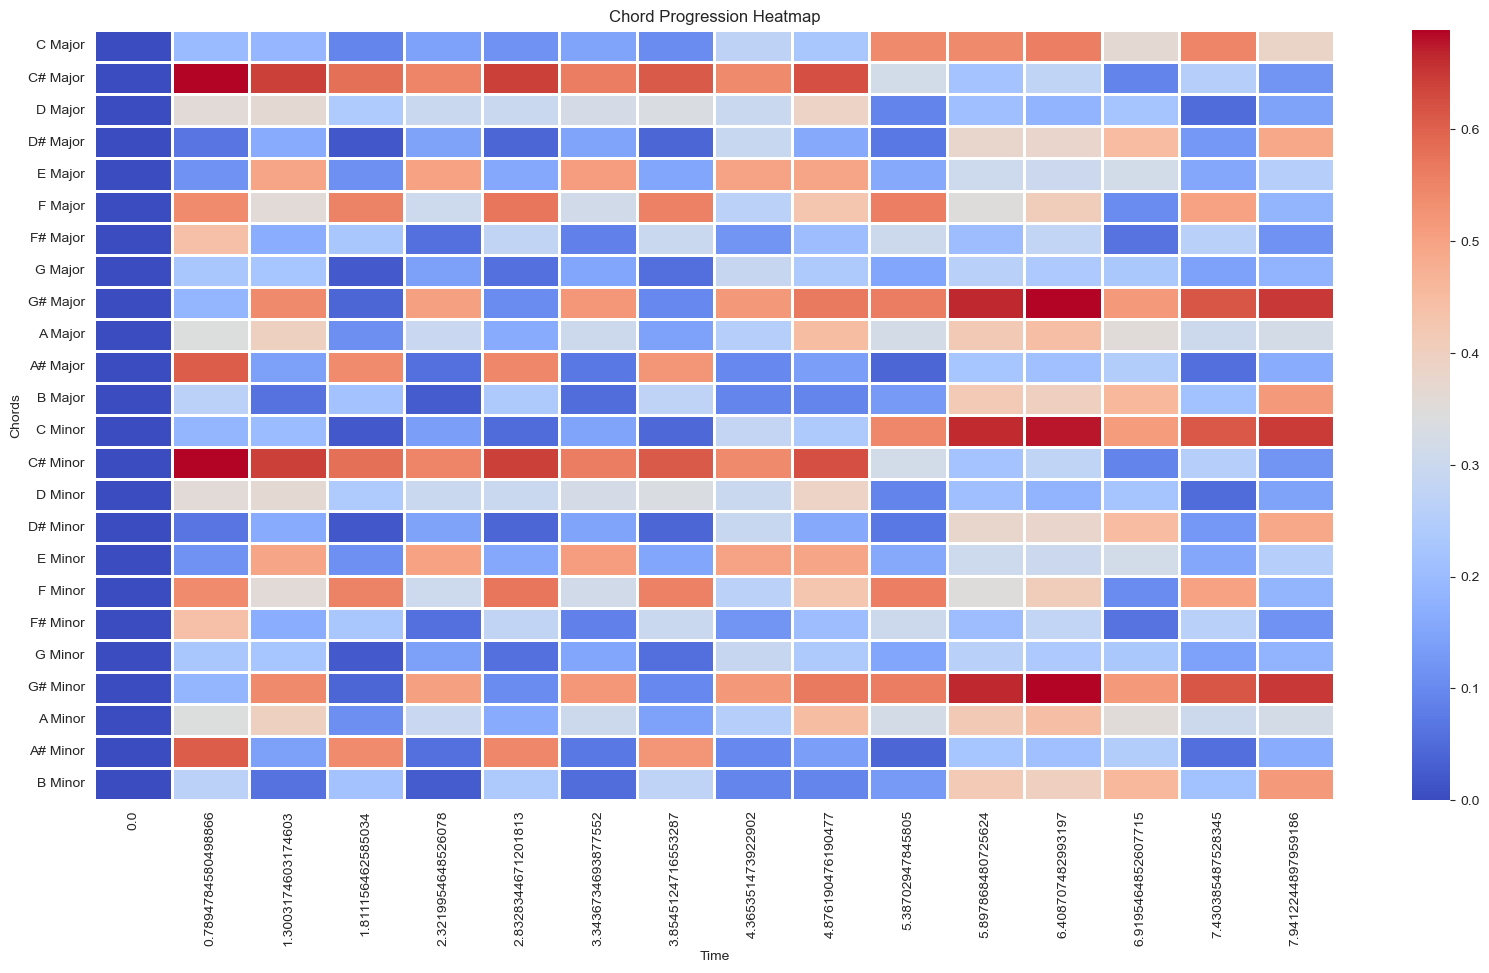

In [171]:
plot_chord_heatmap(sampled_df, window=(0, 8))

# Da normalizzare lungo le colonne (?)